# Evaluations

In [ ]:
import geopandas as gpd

def calculate_precision_recall_f1(confussion_matix):
    """
    Calculate precisoin, recall, and F1 based on the confussion matrix (TP, FP, FN)

    Args:
        confussion_matrix (tuple): confussion matrix values consisting TP, FP, FN.

    Returns:
        tuple: Precision and Recall scores.
    """
    # Confussion matrix values slicing
    true_positives, false_positives, false_negatives = confussion_matix

    # Calculate precision, recall, and F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [ ]:
def prediction_evaluation(prediction, ground_truth, prcat_path, gtcat_path, iou_threshold=0.5):
    """
    Compare prediction results and ground truth polygons and returns ocnfussion matrix values.
    It aslo creates a new column for the category of the polygon for the visualization purpose.

    Args:
        prediction (GeoDataFrame): predicted polygons.
        ground_truth (GeoDataFrame): ground truth polygons.
        prcat_path (String): categorized prediction shapefile output filename and path
        gtcat_path (String): categorized grount truth shapefile output filename and path
        iou_threshold (float): IoU threshold to consider a match (default = 0.5).

    Returns:
        tuple: confussion matrix values (TP, FP, FN).
    """
    # Convert prediction CRS to ground truth CRS
    if prediction.crs != ground_truth.crs:
        prediction = prediction.to_crs(ground_truth.crs)

    # Convert polygons to lists for pairwise comparison
    predicted_polys = list(prediction.geometry)
    ground_truth_polys = list(ground_truth.geometry)

    # Create a copy of prediction's and ground_truth's geodataframe
    # prediction_mod = prediction.copy()
    # prediction_mod = prediction_mod.assign(cat=0) # category column
    # prediction_mod = prediction_mod.assign(iou=0.0) # iou column
    # prediction_mod = prediction_mod.assign(gt_match=-1) # match column
    # groundtr_mod = ground_truth.copy()
    # groundtr_mod = groundtr_mod.assign(cat=0) # category column
    # groundtr_mod = groundtr_mod.assign(iou=0.0) # iou column
    # groundtr_mod = groundtr_mod.assign(gt_match=-1) # match column
    prediction_mod = prediction.copy()
    prediction_mod["cat"] = 0 # category column
    prediction_mod["iou"] = 0.0 # iou column
    prediction_mod["gt_match"]= -1 # match column
    groundtr_mod = ground_truth.copy()
    groundtr_mod["cat"] = 0 # category column
    groundtr_mod["iou"] = 0.0 # iou column
    groundtr_mod["gt_match"]= -1 # match column


    # Track matches
    matched_gt = set()  # Track matched ground truth indices
    duplicated_polys = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    iou_list = []

    # Check each predicted polygon
    for p_idx, pred_poly in enumerate(predicted_polys):
        matched = False
        duplicated = False
        for idx, gt_poly in enumerate(ground_truth_polys):
            # Calculate IoU
            intersection_area = pred_poly.intersection(gt_poly).area
            union_area = pred_poly.union(gt_poly).area
            iou = intersection_area / union_area if union_area > 0 else 0
            prediction_mod.loc[p_idx, 'iou'] = iou # For IoU

            # Check if IoU exceeds threshold
            if iou >= iou_threshold:
                matched = True
                matched_gt.add(idx)  # Mark this ground truth as matched
                groundtr_mod.loc[idx, 'cat'] = 2 # Category 2 for Matched
                if groundtr_mod.loc[idx, 'gt_match'] != -1:
                    duplicated = True
                if groundtr_mod.loc[idx, 'gt_match'] == -1 or groundtr_mod.loc[idx, 'iou'] < iou: #Store the matching prediction
                    groundtr_mod.loc[idx, 'iou'] = iou
                    groundtr_mod.loc[idx, 'gt_match'] = p_idx #
                    # duplicated_polys += 1
                prediction_mod.loc[p_idx, 'gt_match'] = idx # Store the matching ground truth polygon
                break


        if matched:
            true_positives += 1
            prediction_mod.loc[p_idx, 'cat'] = 2 # Category 2 for TP
        else:
            false_positives += 1
            # prediction_mod.loc[p_idx, 'cat'] = 1 # Category 1 for FP

        if duplicated:
            duplicated_polys += 1

    # Re-Count the True positives and False positives considering the duplication
    true_positives = true_positives - duplicated_polys
    false_positives = false_positives

    # Count false negatives (unmatched ground truth polygons)
    false_negatives = len(ground_truth_polys) - len(matched_gt)

    prediction_mod.to_file(prcat_path)
    groundtr_mod.to_file(gtcat_path)

    return true_positives, false_positives, false_negatives

In [ ]:

site_path = "/content/drive/MyDrive/Research/Post_Processing"
pr_path = site_path + "/-"
gt_path = site_path + "/-"

out_pd = site_path + "/-"
out_gt = site_path + "/-"

# Load ground truth shapefile
pr_crown = gpd.read_file(pr_path)
gt_crown = gpd.read_file(gt_path)

# iou = calculate_iou(prediction, ground_truth)
cf_matrix = prediction_evaluation(pr_crown, gt_crown, out_pd, out_gt)
precision, recall, f1_score = calculate_precision_recall_f1(cf_matrix)


# print(f"IoU between prediction and ground truth: {iou}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# DBH Estimation

In [ ]:
import math

def crown_area_to_diameter(crown_area):
    """
    Function to calculate diameter based on tree crown area (m2)

    Args:
        crown_area (float): individual tree crown area

    Returns:
        crown_diameter (float): calcualted crown diameter
    """

    crown_diameter = 2 * math.sqrt(crown_area / math.pi)
    return crown_diameter

def dbh_estimation(crown_diameter):
    """
    Function to estimate tree DBH based on the crown diameter (m)

    Args:
        crown_diameter (float): individual tree crown diameter

    Returns:
        dbh_est (float): estimated tree DBH
    """

    dbh_est = 20.098 + (57.708 - 20.098) / (1 + math.exp(-1.281 * (crown_diameter - 4.5)))
    return dbh_est

# DSM Substaction / Normalization(?)

### subtract

In [ ]:
!pip install git+https://github.com/PatBall1/detectree2.git
!pip install --upgrade --force-reinstall rasterio

  Cloning https://github.com/PatBall1/detectree2.git to /tmp/pip-req-build-9phj21b8
  Running command git clone --filter=blob:none --quiet https://github.com/PatBall1/detectree2.git /tmp/pip-req-build-9phj21b8
  Resolved https://github.com/PatBall1/detectree2.git to commit e640838223bbb136c9475b01eef9162659ba19a5
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-kyxowwri/detectron2_bce32636363746a4b592e78903d9dae7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-kyxowwri/detectron2_bce32636363746a4b592e78903d9dae7
  Resolved https://github.com/facebookresearch/detectron2.git to commit b15f64ec4429e23a148972175a0207c5a9ab84cf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.1/401.1 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import rasterio as rio
import numpy as np

In [ ]:
site_path = "/content/drive/MyDrive/Research/Post_Processing"
img_path = site_path + "/JW_RGB.tif"
dsm_path = site_path + "/JW_DSM.tif"

In [ ]:
# RGB raster
src_img = rio.open(img_path)
ds_img = src_img.read()
src_img.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 7287,
 'height': 6997,
 'count': 4,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]'),
 'transform': Affine(0.014316893097296517, 0.0, 352831.8799,
        0.0, -0.014316907245962567, -17605.8453)}

In [ ]:
# DSM
src_dsm = rio.open(dsm_path)
ds_dsm = src_dsm.read()
src_dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1821,
 'height': 1749,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]'),
 'transform': Affine(0.05726809445362004, 0.0, 352831.8928,
        0.0, -0.05726803887935851, -17605.8515)}

In [ ]:
print(ds_img.shape, ds_dsm.shape)

(4, 6997, 7287) (1, 1749, 1821)


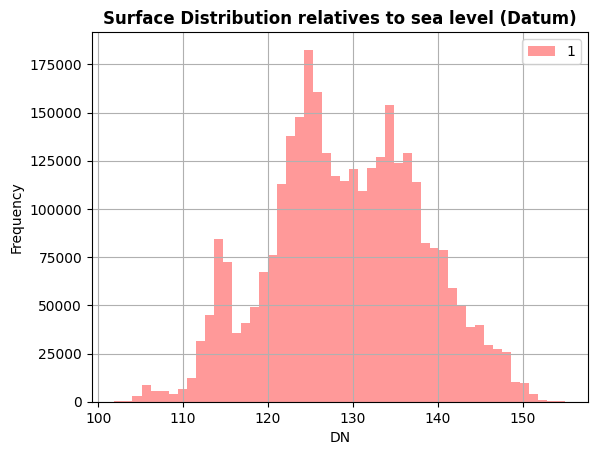

In [ ]:
rio.plot.show_hist(src_dsm, bins=50, lw=0.0, stacked=False, alpha=0.4, histtype='stepfilled', title="Surface Distribution relatives to sea level (Datum)")

In [ ]:
ds_sub = ds_dsm.copy()
ds_sub.shape

(1, 1749, 1821)

In [ ]:
# Subtract DSM with DSM-shaped array filled with lowest value
print(ds_sub.min())

sub_val = np.full((ds_sub.shape), ds_sub.min())
print(sub_val.shape)
print(sub_val)

sub_dsm = ds_sub - sub_val
sub_dsm.shape

print(sub_dsm.shape)
print(sub_dsm)

101.91808
(1, 1749, 1821)
[[[101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]
  [101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]
  [101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]
  ...
  [101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]
  [101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]
  [101.91808 101.91808 101.91808 ... 101.91808 101.91808 101.91808]]]
(1, 1749, 1821)
[[[33.479973  33.38645   33.25312   ... 11.294983  11.303085  11.306877 ]
  [33.532753  33.479546  33.42524   ... 11.294487  11.296173  11.3077545]
  [33.56774   33.52404   33.479576  ... 11.291916  11.293404  11.305222 ]
  ...
  [43.992393  44.02813   44.423775  ... 34.48928   34.57183   34.78266  ]
  [42.723427  43.04711   43.54859   ... 34.392036  34.58689   34.790993 ]
  [42.32264   42.47477   42.874123  ... 34.217262  34.648506  34.843178 ]]]


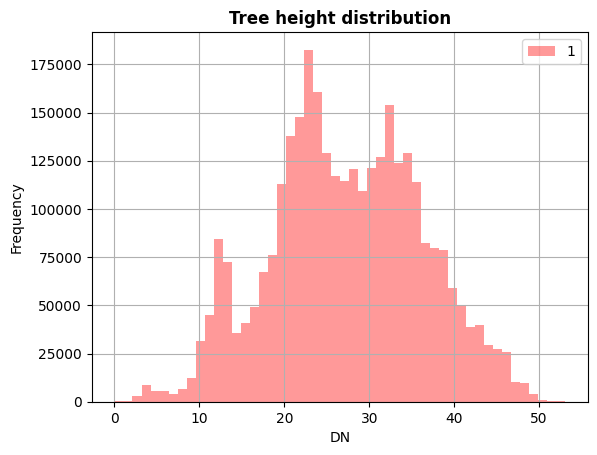

In [ ]:
rio.plot.show_hist(sub_dsm, bins=50, lw=0.0, stacked=False, alpha=0.4, histtype='stepfilled', title="Tree height distribution")

In [ ]:
print("Highest tree: " + str(sub_dsm.max()))
# print("Lowest tree: " + str(sub_dsm[sub_dsm > 0].min()))

Highest tree: 53.09179


In [ ]:
out_meta = src_dsm.meta

dsmsub_path = site_path + "/JW_DSMsub.tif"
with rio.open(dsmsub_path, "w", **out_meta) as dest:
    dest.write(sub_dsm)

In [ ]:
dsmsub_path

'/content/drive/MyDrive/Research/Post_Processing/JW_DSMsub.tif'

### crowns

In [ ]:
!pip install rasterstats

In [ ]:
import geopandas as gpd

crown_path = site_path + "/JW_PR.shp"

pred_crowns = gpd.read_file(crown_path)

In [ ]:
from rasterstats import zonal_stats

In [ ]:
pred_polys = list(pred_crowns.geometry)
print(pred)

[<POLYGON ((352836.898 -17675.576, 352836.912 -17675.59, 352836.998 -17675.59...>, <POLYGON ((352831.953 -17642.112, 352832.059 -17642.217, 352832.073 -17642.2...>, <POLYGON ((352831.972 -17651.237, 352831.973 -17651.237, 352832.002 -17651.2...>, <POLYGON ((352843.77 -17654.186, 352843.784 -17654.201, 352843.799 -17654.20...>, <POLYGON ((352832.038 -17682.928, 352832.044 -17682.935, 352832.087 -17682.9...>, <POLYGON ((352836.955 -17668.045, 352836.97 -17668.059, 352837.428 -17668.05...>, <POLYGON ((352848.752 -17639.311, 352848.767 -17639.325, 352848.981 -17639.3...>, <POLYGON ((352841.694 -17628.903, 352841.708 -17628.917, 352841.78 -17628.91...>, <POLYGON ((352856.297 -17622.875, 352856.312 -17622.89, 352856.498 -17622.89...>, <POLYGON ((352831.905 -17618.709, 352832.03 -17618.709, 352832.044 -17618.69...>, <POLYGON ((352881.452 -17649.333, 352881.466 -17649.347, 352881.567 -17649.3...>, <POLYGON ((352831.955 -17642.776, 352831.959 -17642.776, 352831.973 -17642.7...>, <POLYGON ((3528

In [ ]:
# pc_mod = pred_crowns.copy()
# pc_mod = pred_crowns.assign(=0.0) # category column

# for p_idx, pred_poly in enumerate(pred_polys):
#     poly_stats = zonal_stats(pred_poly, dsmsub_path, stats="max")
#     print(poly_stats[0]["max"])
#     if p_idx == 10:
#         break

In [ ]:
value = 9.3141415
val = round(value, 3)
print(val)

9.314


### fix estimations handler

In [ ]:
!pip install git+https://github.com/PatBall1/detectree2.git
!pip install --upgrade --force-reinstall rasterio

In [ ]:
!pip install rasterstats
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import math
from rasterstats import zonal_stats
import rasterio as rio
import numpy as np

In [ ]:
def dbh_estimation(pred_poly):
    """
    Function to estimate tree DBH based on the crown diameter (cm).
    Crown diameter is derived from the crown area (polygon area) (m2).

    Args:
        pred_poly (shapely.Poygon): polygon of the corresponding tree crown

    Returns:
        dbh_est (float): estimated tree DBH
    """

    # Crown area
    crown_area = pred_poly.area

    # Crown diameter calculation
    crown_diameter = 2 * math.sqrt(crown_area / math.pi)

    # DBH estimation using sigmoidal function (R2 = 0.756, RMSE = 5.22 cm)
    # Coefficient used in this funciton are from (Iizuka, 2022)
    dbh_est = 20.098 + (37.61) / (1 + math.exp(-1.281 * (crown_diameter - 4.5)))
    dbh_est = round(dbh_est, 2)
    return dbh_est


def tree_height_zstats(pred_poly, chm_path):
    """
    Estimate highest CHM raster value on the area of interest (polygon).
    Max value on the polygon zone will be used as the tree height.

    Args:
        pred_poly (shapely.Polygon): polygon of the corresponding tree crown
        chm_path (String): path of the CHM (or subtracted DSM)

    Returns:
        tree_height (float): estimated tree height
    """

    # Zonal statistic of CHM, finding the tree top (maximum height)
    tree_height = zonal_stats(pred_poly, chm_path, stats="max")
    tree_height = round(tree_height[0]["max"], 2)
    return tree_height

def estimations_handler(pred_path, chm_path, out_path):
    """
    Handler for various tree parameters estimations that inlcudes:
        - Tree height estimation
        - DBH estimation

    Args:
        pred_path (String): path of the predicted tree crown polygons
        chm_path (String): path of the CHM (subtracted DSM)

    Returns:
        ???
    """

    # Read crown file and
    pred_crowns = gpd.read_file(crown_path)
    pred_polys = list(pred_crowns.geometry)

    pred_mod = pred_crowns.copy()
    pred_crowns["dbh_est"] = 0.00
    pred_crowns["height_est"] = 0.00
    # pred_mod = pred_mod.assign(dbh_est = 0.0) # dbh column
    # pred_mod = pred_mod.assign(height_est = 0.0) # tree height column

    for p_idx, pred_poly in enumerate(pred_polys):
        dbh_est = dbh_estimation(pred_poly)
        tree_height = tree_height_zstats(pred_poly, chm_path)
        pred_mod.loc[p_idx, 'dbh_est'] = dbh_est # For IoU
        pred_mod.loc[p_idx, 'height_est'] = tree_height # For IoU
        # print("DBH {0} cm \t Height: {1} m".format(dbh_est, tree_height))
        # print("====================================")
        # if p_idx == 20:
        #     break

    pred_mod.to_file(out_path + "/pr_dbh_est3.shp")

    # return something



In [ ]:
# Check functions
site_path = "/content/drive/MyDrive/Research/Post_Processing"
pred_path = site_path + "/JW_PR.shp"
chm_path = site_path + "/JW_DSMsub.tif"

estimations_handler(pred_path, chm_path, site_path)

In [ ]:
dbh_est = 57.22
height_est = 43.65

def above_ground_biomass_est(dbh_est, height_est):
    """
    Estimate the AGB (Above Ground Biomass) based on estimated DBH and height
    Allometric using [Qin, 2021]

    Args:
        dbh_est (float): estimated tree DBH in cm
        height_est (float): estimated tree height in m

    Returns:
        total_AGB (float): total AGB of single tree in kg
    """

    # Above Ground Biomass (AGB) calculation
    stem_AGB = 0.0263 * pow((pow(dbh_est, 2) * height_est), 0.9695)
    branch_AGB = 0.0232 * pow((pow(dbh_est, 2) * height_est), 0.8055)
    leaf_AGB = 0.0075 * pow((pow(dbh_est, 2) * height_est), 0.8015)

    total_AGB = stem_AGB + branch_AGB + leaf_AGB
    # total_AGB = round(total_AGB, 2)
    # print(total_AGB)
    return total_AGB

def carbon_estimations(total_AGB, carbon_coef=0.5)
    """
    Estimate carbon stock of a single tree and its carbon sequestration in kg

    Args:
        total_AGB (float): estimated total ABG of single tree in kg
        carbon_coef (float): carbon coefficient (default = 0.5)

    Returns:
       tuple: estimated carbon stock and sequestration in kg
    """

    # Carbon stock estimation
    carbon_coef = 0.495

    carbon_stock = total_AGB * carbon_coef

    carbon_seq = (44 / 12) * carbon_stock

    return carbon_stock, carbon_seq

# print(above_ground_biomass_est(dbh_est, height_est))

3048.1414519682494
1508.8300187242835
5532.376735322373


In [ ]:
# Check the post-processed prediction data
site_path = "/content/drive/MyDrive/Research/Post_Processing"
pred_path = site_path + "/pr_dbh_est3.shp"
pred_crowns = gpd.read_file(pred_path)
pred_polys = list(pred_crowns.geometry)

pred_crowns.head()

,fid,Confidence,cat,iou,gt_match,dbh_est,height_est,geometry
0,1.0,0.503610372543335,2.0,0.719680,16.0,57.22,43.65,"POLYGON ((352836.898 -17675.576, 352836.912 -1..."
1,2.0,0.2679292559623718,2.0,0.774424,188.0,53.65,38.74,"POLYGON ((352831.953 -17642.112, 352832.059 -1..."
2,3.0,0.2404603064060211,0.0,0.000000,-1.0,57.70,42.06,"POLYGON ((352831.972 -17651.237, 352831.973 -1..."
3,4.0,0.183594286441803,0.0,0.000000,-1.0,57.69,37.31,"POLYGON ((352843.77 -17654.186, 352843.784 -17..."
4,5.0,0.346139520406723,2.0,0.674830,165.0,48.18,44.88,"POLYGON ((352832.038 -17682.928, 352832.044 -1..."


In [ ]:
def dbh_estimation(pred_poly):
    """
    Function to estimate tree DBH based on the crown diameter (cm).
    Crown diameter is derived from the crown area (polygon area) (m2).

    Args:
        pred_poly (shapely.Poygon): polygon of the corresponding tree crown

    Returns:
        dbh_est (float): estimated tree DBH
    """

    # Crown area
    crown_area = pred_poly.area

    # Crown diameter calculation
    crown_diameter = 2 * math.sqrt(crown_area / math.pi)

    # DBH estimation using sigmoidal function (R2 = 0.756, RMSE = 5.22 cm)
    # Coefficient used in this funciton are from (Iizuka, 2022)
    dbh_est = 20.098 + (37.61) / (1 + math.exp(-1.281 * (crown_diameter - 4.5)))
    dbh_est = round(dbh_est, 2)
    return dbh_est


def tree_height_zstats(pred_poly, chm_path):
    """
    Estimate highest CHM raster value on the area of interest (polygon).
    Max value on the polygon zone will be used as the tree height.

    Args:
        pred_poly (shapely.Polygon): polygon of the corresponding tree crown
        chm_path (String): path of the CHM (or subtracted DSM)

    Returns:
        tree_height (float): estimated tree height
    """

    # Zonal statistic of CHM, finding the tree top (maximum height)
    tree_height = zonal_stats(pred_poly, chm_path, stats="max")
    tree_height = round(tree_height[0]["max"], 2)
    return tree_height

def above_ground_biomass_est(dbh_est, height_est):
    """
    Estimate the AGB (Above Ground Biomass) based on estimated DBH and height
    Allometric using [Qin, 2021]

    Args:
        dbh_est (float): estimated tree DBH in cm
        height_est (float): estimated tree height in m

    Returns:
        total_AGB (float): total AGB of single tree in kg
    """

    # Above Ground Biomass (AGB) calculation
    stem_AGB = 0.0263 * pow((pow(dbh_est, 2) * height_est), 0.9695)
    branch_AGB = 0.0232 * pow((pow(dbh_est, 2) * height_est), 0.8055)
    leaf_AGB = 0.0075 * pow((pow(dbh_est, 2) * height_est), 0.8015)

    total_AGB = stem_AGB + branch_AGB + leaf_AGB
    total_AGB = round(total_AGB, 2)
    # print(total_AGB)
    return total_AGB

def carbon_estimations(total_AGB, carbon_coef=0.5):
    """
    Estimate carbon stock of a single tree and its carbon sequestration in kg

    Args:
        total_AGB (float): estimated total ABG of single tree in kg
        carbon_coef (float): carbon coefficient (default = 0.5)

    Returns:
       tuple: estimated carbon stock and sequestration in kg
    """

    # Carbon stock estimation
    carbon_coef = 0.495

    carbon_stock = total_AGB * carbon_coef

    carbon_seq = (44 / 12) * carbon_stock

    carbon_stock = round(carbon_stock, 2)
    carbon_seq = round(carbon_seq, 2)

    return carbon_stock, carbon_seq

def estimations_handler(pred_path, chm_path, out_path, out_file):
    """
    Handler for various tree parameters estimations that inlcudes:
        - Tree height estimation
        - DBH estimation
        - AGB estimation
        - Carbon stock estimation

    Args:
        pred_path (String): path of the predicted tree crown polygons
        chm_path (String): path of the CHM (subtracted DSM)

    Returns:
        ???
    """

    # Read crown file and
    pred_crowns = gpd.read_file(pred_path)
    pred_polys = list(pred_crowns.geometry)

    pred_mod = pred_crowns.copy()
    pred_crowns["dbh_est"] = 0.00
    pred_crowns["height_est"] = 0.00
    pred_crowns["total_agb"] = 0.00
    pred_crowns["carbon_stc"] = 0.00
    pred_crowns["carbon_seq"] = 0.00

    for p_idx, pred_poly in enumerate(pred_polys):
        dbh_est = dbh_estimation(pred_poly)
        tree_height = tree_height_zstats(pred_poly, chm_path)
        total_AGB = above_ground_biomass_est(dbh_est, tree_height)
        carbon_stock, carbon_seq = carbon_estimations(total_AGB)
        pred_mod.loc[p_idx, 'dbh_est'] = dbh_est # DBH estimation
        pred_mod.loc[p_idx, 'height_est'] = tree_height # Height estimation
        pred_mod.loc[p_idx, 'total_agb'] = total_AGB # Total AGB
        pred_mod.loc[p_idx, 'carbon_stc'] = carbon_stock # Carbon stock
        pred_mod.loc[p_idx, 'carbon_seq'] = carbon_seq # Carbon sequestration
        # print("====================================")
        # if p_idx == 20:
        #     break

    pred_mod.to_file(out_path + "/" + out_file)

    # return something



In [ ]:
# Check functions
site_path = "/content/drive/MyDrive/Research/Post_Processing"
pred_path = site_path + "/JW_PR.shp"
chm_path = site_path + "/JW_DSMsub.tif"
out_file = "pr_dbh_est5.shp"

estimations_handler(pred_path, chm_path, site_path, out_file)

In [ ]:
check_path = site_path + "/" + out_file
check_crowns = gpd.read_file(check_path)
check_polys = list(check_crowns.geometry)

check_crowns.head(10)

,fid,Confidence,cat,iou,gt_match,dbh_est,height_est,total_agb,carbon_stc,carbon_seq,geometry
0,1.0,0.503610372543335,2.0,0.719680,16.0,57.22,43.65,3048.14,1508.83,5532.37,"POLYGON ((352836.898 -17675.576, 352836.912 -1..."
1,2.0,0.2679292559623718,2.0,0.774424,188.0,53.65,38.74,2410.46,1193.18,4374.98,"POLYGON ((352831.953 -17642.112, 352832.059 -1..."
2,3.0,0.2404603064060211,0.0,0.000000,-1.0,57.70,42.06,2989.88,1479.99,5426.63,"POLYGON ((352831.972 -17651.237, 352831.973 -1..."
3,4.0,0.183594286441803,0.0,0.000000,-1.0,57.69,37.31,2668.59,1320.95,4843.49,"POLYGON ((352843.77 -17654.186, 352843.784 -17..."
4,5.0,0.346139520406723,2.0,0.674830,165.0,48.18,44.88,2260.50,1118.95,4102.81,"POLYGON ((352832.038 -17682.928, 352832.044 -1..."
5,6.0,0.2421440482139587,2.0,0.797044,38.0,56.19,39.48,2678.31,1325.76,4861.13,"POLYGON ((352836.955 -17668.045, 352836.97 -17..."
6,7.0,0.7754576802253723,2.0,0.873721,71.0,57.71,37.14,2658.83,1316.12,4825.78,"POLYGON ((352848.752 -17639.311, 352848.767 -1..."
7,8.0,0.572208046913147,2.0,0.867230,126.0,57.71,43.76,3105.11,1537.03,5635.77,"POLYGON ((352841.694 -17628.903, 352841.708 -1..."
8,9.0,0.5465477705001831,0.0,0.000000,-1.0,57.71,35.49,2547.00,1260.77,4622.81,"POLYGON ((352856.297 -17622.875, 352856.312 -1..."
9,10.0,0.4964763522148132,2.0,0.526236,159.0,57.67,40.69,2894.81,1432.93,5254.08,"POLYGON ((352831.905 -17618.709, 352832.03 -17..."


<Axes: title={'center': 'Tree height distribution'}, xlabel='fid'>

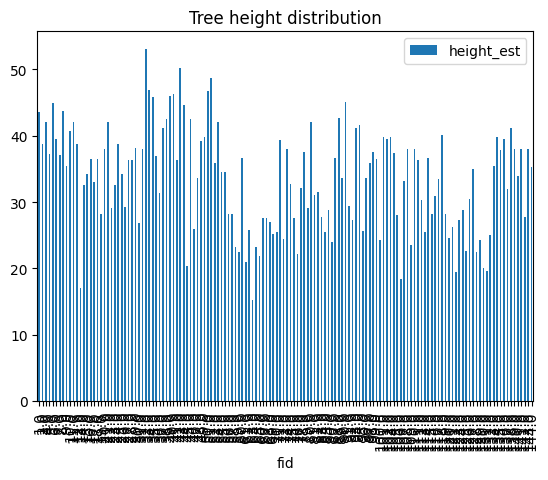

In [ ]:
check_crowns.plot.bar(x="fid", y="height_est", title="Tree height distribution")

Text(0, 0.5, 'Number of trees')

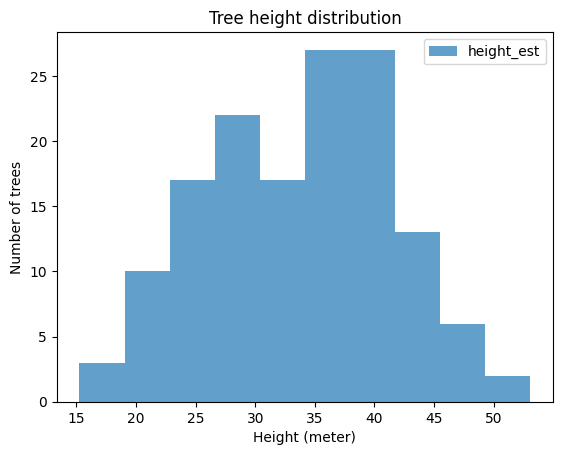

In [ ]:
ax = check_crowns.plot.hist(column=["height_est"], stacked=False, alpha=0.7,
                           histtype='stepfilled', title="Tree height distribution")
ax.set_xlabel("Height (meter)")
ax.set_ylabel("Number of trees")

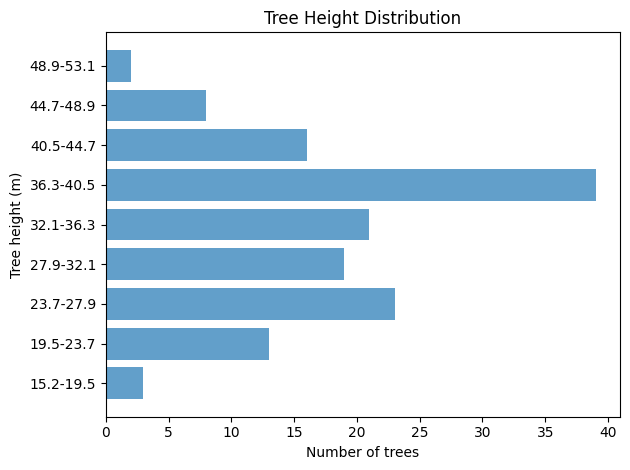

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

heights = check_crowns["height_est"]

counts, bin_edges = np.histogram(heights, bins='auto')

bin_ranges = [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]

plt.barh(bin_ranges, counts, alpha=0.7)
# plt.barh(bin_ranges, counts, alpha=0.7, edgecolor='black')


plt.xlabel("Number of trees")
plt.ylabel("Tree height (m)")
plt.title("Tree Height Distribution")
plt.tight_layout()
plt.show()

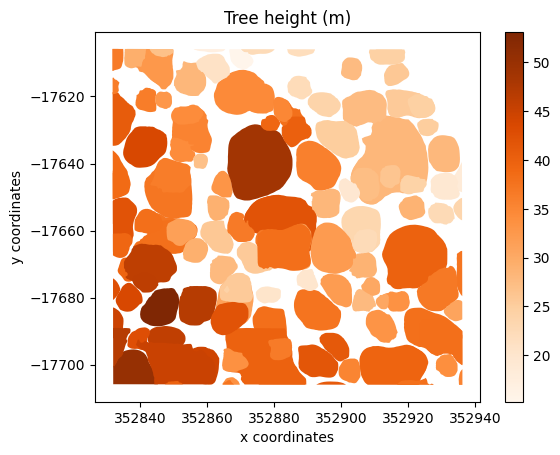

In [88]:
check_poly = check_crowns["geometry"]
check_crowns.plot(column="height_est", cmap="Oranges", legend=True)
plt.title("Tree height (m)")
plt.xlabel("x coordinates")
plt.ylabel("y coordinates")
plt.show()

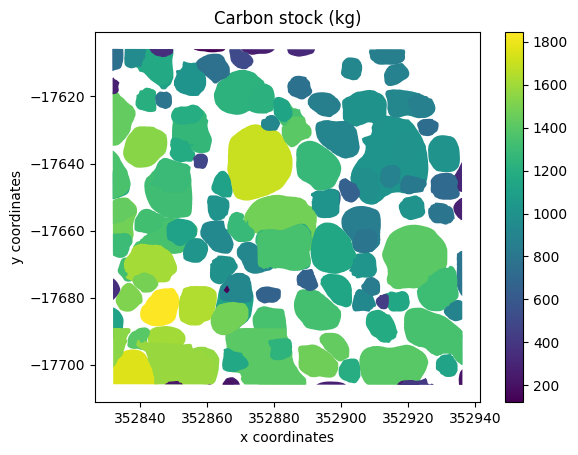

In [79]:
check_poly = check_crowns["geometry"]
check_crowns.plot(column="carbon_stc", cmap="viridis", legend=True)
plt.title("Carbon stock (kg)")
plt.xlabel("x coordinates")
plt.ylabel("y coordinates")
# plt.axis('off')
plt.show()

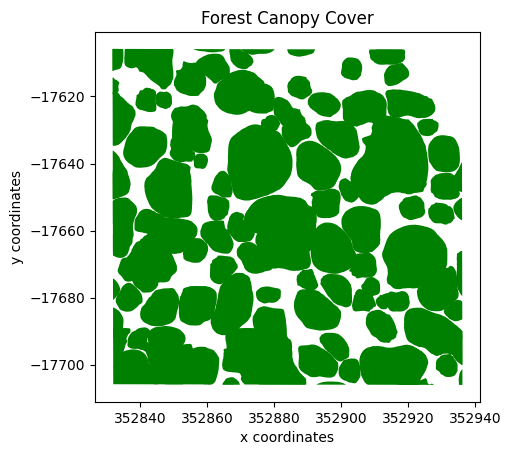

In [ ]:
check_poly = check_crowns["geometry"]
check_crowns.plot(color="green")
plt.title("Forest Canopy Cover")
plt.xlabel("x coordinates")
plt.ylabel("y coordinates")
plt.show()